<a href="https://colab.research.google.com/github/vengottip/Work/blob/main/CS_598_Project1_Ames_Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install feature_engine
!pip install glmnet_py #Install the correct glmnet package
!pip install xgboost
!pip install lightgbm
!pip install --upgrade scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.3/378.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
# Data manipulation and scientific computation
import pandas as pd
import numpy as np
from scipy import stats

# Machine Learning models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Scikit-learn (for various ML algorithms and utilities)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Categorical encoders
import category_encoders as ce

# Handling outliers
from feature_engine.outliers import Winsorizer

# GLMNET for regularized regression
#from glmnet_python import glmnet
#from glmnet_python import glmnetPrint

# GLMNET for regularized regression
#from glmnet import glmnet  # Correct glmnet package for Python


# R interface for Python
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

# Activate pandas to R data conversion
pandas2ri.activate()

print("Packages successfully imported!")


Packages successfully imported!


In [ ]:
warnings.filterwarnings("ignore")

def load_data(train_path, test_path):
    """Load train and test CSV files into pandas DataFrames."""
    try:
        # Load the CSV files
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        print(f"Train data loaded: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
        print(f"Test data loaded: {test_df.shape[0]} rows, {test_df.shape[1]} columns")

        return train_df, test_df
    except Exception as e:
        print(f"Error loading files: {e}")
        return None, None

def main():
    # Paths to train and test CSV files
    train_path = "train.csv"
    test_path = "test.csv"

    # Load the train and test datasets
    train_df, test_df = load_data(train_path, test_path)

    if train_df is not None and test_df is not None:
        # Example: Print the first few rows of the train and test datasets
        print("\nFirst 5 rows of the train dataset:")
        print(train_df.head())

        print("\nFirst 5 rows of the test dataset:")
        print(test_df.head())

if __name__ == "__main__":
    main()


Error loading files: [Errno 2] No such file or directory: 'train.csv'


In [ ]:
# Load the dataset
housing_data = pd.read_csv('train.csv')

# List all the column names
column_names = housing_data.columns.tolist()
#column_names

# Identify categorical columns
categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                       'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                       'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                       'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                       'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                       'Misc_Feature', 'Sale_Type', 'Sale_Condition']

# Perform dummy encoding (drop_first=True to avoid multicollinearity)
housing_data_encoded = pd.get_dummies(housing_data, columns=categorical_columns, drop_first=True)

# Get all columns that were created after dummy encoding
#encoded_columns = [col for col in housing_data_encoded.columns if col not in housing_data.columns]
#print("encoded_columns.count",encoded_columns)

# Correct approach to only get the newly created dummy-encoded columns
encoded_columns = [col for col in housing_data_encoded.columns if any(cat_col in col for cat_col in categorical_columns)]
print("encoded_columns.count",encoded_columns)
# Convert boolean columns to integers (True to 1, False to 0)
housing_data_encoded[encoded_columns] = housing_data_encoded[encoded_columns].astype(int)

# Display the first few rows of the encoded DataFrame with integers
housing_data_encoded[encoded_columns].head()



encoded_columns.count ['MS_SubClass_One_Story_1945_and_Older', 'MS_SubClass_One_Story_1946_and_Newer_All_Styles', 'MS_SubClass_One_Story_PUD_1946_and_Newer', 'MS_SubClass_One_Story_with_Finished_Attic_All_Ages', 'MS_SubClass_One_and_Half_Story_Finished_All_Ages', 'MS_SubClass_One_and_Half_Story_Unfinished_All_Ages', 'MS_SubClass_PUD_Multilevel_Split_Level_Foyer', 'MS_SubClass_Split_Foyer', 'MS_SubClass_Split_or_Multilevel', 'MS_SubClass_Two_Family_conversion_All_Styles_and_Ages', 'MS_SubClass_Two_Story_1945_and_Older', 'MS_SubClass_Two_Story_1946_and_Newer', 'MS_SubClass_Two_Story_PUD_1946_and_Newer', 'MS_SubClass_Two_and_Half_Story_All_Ages', 'MS_Zoning_C_all', 'MS_Zoning_Floating_Village_Residential', 'MS_Zoning_I_all', 'MS_Zoning_Residential_High_Density', 'MS_Zoning_Residential_Low_Density', 'MS_Zoning_Residential_Medium_Density', 'Street_Pave', 'Alley_No_Alley_Access', 'Alley_Paved', 'Lot_Shape_Moderately_Irregular', 'Lot_Shape_Regular', 'Lot_Shape_Slightly_Irregular', 'Land_Conto

,MS_SubClass_One_Story_1945_and_Older,MS_SubClass_One_Story_1946_and_Newer_All_Styles,MS_SubClass_One_Story_PUD_1946_and_Newer,MS_SubClass_One_Story_with_Finished_Attic_All_Ages,MS_SubClass_One_and_Half_Story_Finished_All_Ages,MS_SubClass_One_and_Half_Story_Unfinished_All_Ages,MS_SubClass_PUD_Multilevel_Split_Level_Foyer,MS_SubClass_Split_Foyer,MS_SubClass_Split_or_Multilevel,MS_SubClass_Two_Family_conversion_All_Styles_and_Ages,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Function to calculate RMSE
def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
# Backward elimination function (based on coefficient values for regularization)
def backward_elimination_ridge(X, y, alpha=1.0):
    # Fit the Ridge model
    model = Ridge(alpha=alpha).fit(X, y)
    # Identify features with very small coefficients and drop them
    while True:
        coefs = model.coef_
        smallest_coef = np.argmin(np.abs(coefs))
        if np.abs(coefs[smallest_coef]) < 1e-4:  # Threshold for eliminating small coefficients
            X = X.drop(X.columns[smallest_coef], axis=1)
            model = Ridge(alpha=alpha).fit(X, y)
        else:
            break
    return model

In [ ]:
# Function to calculate AIC for a linear regression model
def calculate_aic(n, rss, k):
    """Calculate AIC (Akaike Information Criterion).
    n: Number of observations
    rss: Residual Sum of Squares (from model)
    k: Number of parameters (number of features + intercept)
    """
    return n * np.log(rss / n) + 2 * k


In [ ]:
# Backward elimination based on AIC with Ridge regression
def backward_elimination_ridge_aic(X, y, alpha=1.0):
    # Initialize the Ridge regression model
    model = Ridge(alpha=alpha)

    # Start with all features
    X_current = X.copy()

    # Track removed features and how many were removed
    removed_features = []
    num_removed = 0

    # Fit the model with all predictors
    model.fit(X_current, y)
    n = len(y)  # Number of observations
    residuals = y - model.predict(X_current)
    rss = np.sum(residuals**2)  # Calculate Residual Sum of Squares (RSS)
    k = X_current.shape[1] + 1  # Number of features + intercept

    aic_current = calculate_aic(n, rss, k)

    while True:
        aic_old = aic_current


        # Fit the model and calculate t-statistics (approximate p-values using t-statistics)
        model.fit(X_current, y)
        pvalues = np.abs(model.coef_) / np.std(X_current, axis=0)  # Approximation of t-statistics
        print("pvalues", pvalues)
        # Remove feature with the smallest t-statistic (or largest p-value approximation)
        worst_feature_idx = np.argmin(pvalues)
        worst_feature = X_current.columns[worst_feature_idx]
        print("Worst Feature", worst_feature)
        # Drop the worst feature
        X_new = X_current.drop(columns=[worst_feature])

        # Track the removed feature
        removed_features.append(worst_feature)
        num_removed += 1


        # Fit the new Ridge model and calculate AIC again
        model.fit(X_new, y)
        residuals_new = y - model.predict(X_new)
        rss_new = np.sum(residuals_new**2)  # Recalculate RSS
        k_new = X_new.shape[1] + 1  # Number of features + intercept
        aic_new = calculate_aic(n, rss_new, k_new)
        print("AIC_old", aic_old)
        print("AIC_new", aic_new)
        # If AIC improves (decreases), keep the new model, else stop
        if aic_new < aic_old:
            X_current = X_new
            aic_current = aic_new
            print("AIC_current", aic_current)
            print("X_current", X_current.columns.size)
        else:
            print("AIC_current_before_Break", aic_current)
            break
    print("Num Removed", num_removed)
    print("Removed Features", removed_features)
    print("X_current", X_current.columns.size)
    return model, X_new, removed_features

In [ ]:
# Assuming ridge_model_mse is already defined somewhere in your code
# from ridge_model_mse import ridge_model_mse

def calc_rmse(actual, predicted):
    """Calculate Root Mean Squared Error."""
    return np.sqrt(np.mean((actual - predicted) ** 2))

In [ ]:
def main():
    # Load the dataset
    file_path = 'train.csv'
    housing_data = pd.read_csv(file_path)

    # Verify column names and check if Sale_Price exists
    if 'Sale_Price' not in housing_data.columns:
        print("Error: 'Sale_Price' column not found in the dataset.")
        print("Available columns:", housing_data.columns)
        return

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on the entire dataset
    housing_data_encoded = pd.get_dummies(housing_data, columns=categorical_columns, drop_first=True)
    housing_data_encoded.head()
    # Handle missing values by imputing them (e.g., using median imputation)
    imputer = SimpleImputer(strategy='median')
    housing_data_encoded_imputed = pd.DataFrame(imputer.fit_transform(housing_data_encoded), columns=housing_data_encoded.columns)

    # Ensure no missing values remain
    if housing_data_encoded_imputed.isna().sum().any():
        print("Error: There are still NaN values after imputation.")
        return

    # Now split the imputed dataset into 80% training and 20% testing
    #car_data_trn, car_data_tst = train_test_split(housing_data_encoded_imputed, test_size=0.20, random_state=42)

    # ** Remove PID from the features as it is just an identifier **
    housing_data_encoded_imputed_train = housing_data_encoded_imputed.drop(columns=['PID'])
    #car_data_tst = car_data_tst.drop(columns=['PID'])

    # Ensure consistent feature names
    housing_data_encoded_imputed_train.columns = housing_data_encoded_imputed_train.columns.str.strip()
    #car_data_tst.columns = car_data_tst.columns.str.strip()


    # Separate predictors (X) and target variable (y) for training and testing sets
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])  # Log-transform the target variable for training set

    #X_tst = car_data_tst.drop(columns='Sale_Price')
    #y_tst = np.log(car_data_tst['Sale_Price'])  # Log-transform the target variable for test set

    # Ensure Sale_Price contains no zeros or negative values before log-transforming
    if (housing_data_encoded_imputed_train['Sale_Price'] <= 0).sum() > 0 or (housing_data_encoded_imputed_train['Sale_Price'] <= 0).sum() > 0:
        print("Error: 'Sale_Price' contains non-positive values, cannot apply log transformation.")
        return

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, _ = backward_elimination_ridge_aic(X_trn, y_trn, alpha=1.0)
    print("X_trn", X_trn.columns)
    #print("X_tst", X_tst.columns)
    print("Final Features (Ridge):", final_features_trn.columns)

    # Number of features in training and test sets
    print("Number of Features in X_trn:", X_trn.shape[1])
    #print("Number of Features in X_tst:", X_tst.shape[1])
    print("Number of Features in final_features_trn:", final_features_trn.shape[1])
    #print("Number of Features in final_features_tst:", final_features_tst.shape[1])
    # Find the intersection between final features and categorical columns
    categorical_features_in_final = [col for col in final_features_trn.columns if col in categorical_columns]

    # Print the categorical features
    print("Categorical Features in final_features_trn:", categorical_features_in_final)

    # Print adjusted R-squared for the Ridge model after backward elimination
    y_trn_pred = model_ridge.predict(final_features_trn)
    r2_adj = 1 - (1 - r2_score(y_trn, y_trn_pred)) * (len(y_trn) - 1) / (len(y_trn) - final_features_trn.shape[1] - 1)
    print("Adjusted R-squared (Training):", r2_adj)

    # For the test set, we need to reduce the test set to the same final set of features
    #final_features_tst = X_tst[final_features_trn.columns]

    # Predict on the test set using the reduced features
    #y_tst_pred = model_ridge.predict(final_features_tst)
    #test_rmse = calc_rmse(y_tst, y_tst_pred)
    #print("Test RMSE:", test_rmse)

if __name__ == "__main__":
    main()


pvalues Lot_Frontage              3.601671e-06
Lot_Area                  2.401535e-10
Year_Built                4.333100e-05
Year_Remod_Add            3.156582e-05
Mas_Vnr_Area              1.046480e-07
                              ...     
Sale_Condition_AdjLand    2.298149e+00
Sale_Condition_Alloca     1.178436e+00
Sale_Condition_Family     1.259268e-01
Sale_Condition_Normal     2.044621e-01
Sale_Condition_Partial    4.622664e-01
Length: 294, dtype: float64
Worst Feature Lot_Area
AIC_old -8626.592797409803
AIC_new -8615.812035321345
AIC_current_before_Break -8626.592797409803
Num Removed 1
Removed Features ['Lot_Area']
X_current 294
X_trn Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF',
       ...
       'Sale_Type_ConLw', 'Sale_Type_New', 'Sale_Type_Oth', 'Sale_Type_VWD',
       'Sale_Type_WD', 'Sale_Condition_AdjLand', 'Sale_Condition_Alloca',
       'Sal

In [ ]:
def main():
    # Load the train and test datasets
    train_file_path = 'train.csv'
    test_file_path = 'test.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on the train dataset
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(housing_data_test, columns=categorical_columns, drop_first=True)

    # Handle missing values by imputing them (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'
    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Align the columns of the test dataset to match the train dataset
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.reindex(columns=housing_data_encoded_imputed_train.columns.drop('Sale_Price'), fill_value=0)

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic(X_trn, y_trn, alpha=1.0)

    # Remove the same features from the test dataset
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features, errors='ignore')

    # Predict on the test set using the trained Ridge model
    y_tst_pred = model_ridge.predict(X_tst)

    # Output some model info
    print("Final Features (Ridge):", final_features_trn.columns)
    print("Number of Features in X_trn:", X_trn.shape[1])
    print("Number of Features in final_features_trn:", final_features_trn.shape[1])
    print("Removed Features:", removed_features)

if __name__ == "__main__":
    main()


pvalues Lot_Frontage              3.601671e-06
Lot_Area                  2.401535e-10
Year_Built                4.333100e-05
Year_Remod_Add            3.156582e-05
Mas_Vnr_Area              1.046480e-07
                              ...     
Sale_Condition_AdjLand    2.298149e+00
Sale_Condition_Alloca     1.178436e+00
Sale_Condition_Family     1.259268e-01
Sale_Condition_Normal     2.044621e-01
Sale_Condition_Partial    4.622664e-01
Length: 294, dtype: float64
Worst Feature Lot_Area
AIC_old -8626.592797409803
AIC_new -8615.812035321345
AIC_current_before_Break -8626.592797409803
Num Removed 1
Removed Features ['Lot_Area']
X_current 294
Final Features (Ridge): Index(['Lot_Frontage', 'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area',
       'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'First_Flr_SF', 'Second_Flr_SF',
       ...
       'Sale_Type_ConLw', 'Sale_Type_New', 'Sale_Type_Oth', 'Sale_Type_VWD',
       'Sale_Type_WD ', 'Sale_Condition_AdjLand', 'Sale_Condit

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings

def ridge_model_mse(X_train, y_train, X_test, y_test):
    """
    Performs Ridge regression with cross-validation to select the optimal alpha
    and returns the Mean Squared Error (MSE) on the test data.

    Parameters:
    X_train: Training feature matrix (DataFrame or numpy array)
    y_train: Training response vector (Series or numpy array)
    X_test: Testing feature matrix (DataFrame or numpy array)
    y_test: Testing response vector (Series or numpy array)

    Returns:
    mse: Mean Squared Error on the test data
    alpha: Optimal alpha value selected by cross-validation
    """
    # Ignore any warnings that may arise from using this method
    warnings.filterwarnings("ignore")

    # Define the range of alpha values for Ridge regression
    ridge_alphas = np.logspace(-10, 1, 100)

    # Create a Ridge regression model with cross-validation
    ridgecv = RidgeCV(alphas=ridge_alphas, cv=10, scoring='neg_mean_squared_error', normalize=True)

    # Fit the model on the training data
    ridgecv.fit(X_train, y_train)

    # Predict on the test data
    y_pred = ridgecv.predict(X_test)

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Get the optimal alpha selected by RidgeCV
    alpha = ridgecv.alpha_

    return mse, alpha

# Example usage:
# mse, alpha = ridge_model_mse(X_train, y_train, X_test, y_test)
# print(f"Optimal Alpha: {alpha}, Test MSE: {mse}")


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def calc_rmse(actual, predicted):
    """Calculate Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((actual - predicted) ** 2))

def adjusted_r_squared(r2, n, k):
    """Calculate the adjusted R-squared."""
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def main():
    # Load the train and test datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on the train dataset
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(housing_data_test, columns=categorical_columns, drop_first=True)

    # Handle missing values by imputing them in train and test data (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'
    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Align the columns of the test dataset to match the train dataset
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.reindex(columns=housing_data_encoded_imputed_train.columns.drop('Sale_Price'), fill_value=0)

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic(X_trn, y_trn, alpha=1.0)

    # Remove the same features from the test dataset
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features, errors='ignore')

    # Predict on the training set
    y_trn_pred = model_ridge.predict(final_features_trn)

    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred = model_ridge.predict(X_tst)

    # Evaluate on the test data (assuming test.csv has a Sale_Price column)
    if 'Sale_Price' in housing_data_encoded_test.columns:
        y_tst = np.log(housing_data_encoded_test['Sale_Price'])  # Log-transform the target variable for test set

        # Calculate R-squared and adjusted R-squared for the test data
        r2_test = r2_score(y_tst, y_tst_pred)
        adj_r2_test = adjusted_r_squared(r2_test, len(y_tst), X_tst.shape[1])

        # Calculate RMSE for the test data
        test_rmse = calc_rmse(y_tst, y_tst_pred)

        print("Test R-squared:", r2_test)
        print("Adjusted R-squared (Test):", adj_r2_test)
        print("Test RMSE:", test_rmse)
    else:
        print("Warning: 'Sale_Price' column not found in test.csv. Unable to calculate RMSE.")

    # Output some model info
    print("Final Features (Ridge):", final_features_trn.columns)
    print("Number of Features in X_trn:", X_trn.shape[1])
    print("Number of Features in final_features_trn:", final_features_trn.shape[1])
    print("Removed Features:", removed_features)

if __name__ == "__main__":
    main()




pvalues Lot_Frontage              7.021858e-06
Lot_Area                  2.483740e-10
Year_Built                5.506122e-05
Year_Remod_Add            3.579071e-05
Mas_Vnr_Area              2.808985e-07
                              ...     
Sale_Condition_AdjLand    2.902729e+00
Sale_Condition_Alloca     9.076733e-01
Sale_Condition_Family     1.054023e-01
Sale_Condition_Normal     1.976220e-01
Sale_Condition_Partial    1.124487e-01
Length: 299, dtype: float64
Worst Feature Lot_Area
AIC_old -8630.848000367878
AIC_new -8623.131287761094
AIC_current_before_Break -8630.848000367878
Num Removed 1
Removed Features ['Lot_Area']
X_current 299
Training R-squared: 0.9347714813063736
Adjusted R-squared (Training): 0.9236766761861106
Training RMSE: 0.10561447472218422
Final Features (Ridge): Index(['Lot_Frontage', 'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area',
       'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'First_Flr_SF', 'Second_Flr_SF',
       ...
       'Sale_Ty

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # 1. Use Lasso regression for feature selection
    lasso_model = Lasso(alpha=0.01)  # Adjust the alpha value as necessary
    lasso_model.fit(X_trn_scaled, y_trn)

    # Select the features with non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after Lasso: {len(selected_features)} features")

    # Scale the test data using the same scaler
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])), columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    print("X_tst_scaled shape", X_tst_scaled.shape)



    # 2. Grid Search for Ridge Regression to find the best alpha
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
    ridge_model = Ridge()
    grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_trn_scaled[selected_features], y_trn)

    # Get the best alpha value from grid search
    best_alpha = grid_search.best_params_['alpha']
    print("Best alpha for Ridge regression:", best_alpha)

    # 3. Train the final Ridge model with the best alpha
    final_ridge_model = Ridge(alpha=best_alpha)
    final_ridge_model.fit(X_trn_scaled[selected_features], y_trn)

    # Predict on the training set
    y_trn_pred = final_ridge_model.predict(X_trn_scaled[selected_features])

    # Calculate R-squared and RMSE for training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), X_trn_scaled[selected_features].shape[1])
    train_rmse = calc_rmse(y_trn, y_trn_pred)
    print(f"Training R-squared: {r2_train}")
    print(f"Adjusted R-squared (Training): {adj_r2_train}")
    print(f"Training RMSE: {train_rmse}")

    # Predict on the test set
    y_tst_pred_log = final_ridge_model.predict(X_tst_scaled[selected_features])

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Selected features after Lasso: 69 features
X_tst_scaled shape (879, 305)
Best alpha for Ridge regression: 100
Training R-squared: 0.9167256386576015
Adjusted R-squared (Training): 0.9138251182473918
Training RMSE: 0.11933294006933579
Test RMSE: 0.1316017987470567
Test R-squared: 0.887759206256692
Adjusted R-squared (Test): 0.8280149792205508
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Helper function to calculate RMSE
def calc_rmse(actual, predicted):
    """Calculate Root Mean Squared Error."""
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Helper function to calculate adjusted R-squared
def adjusted_r_squared(r2, n, k):
    """Calculate adjusted R-squared."""
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Placeholder for backward elimination with Ridge regression
def backward_elimination_ridge_aic1(X, y, alpha=1.0):
    model = Ridge(alpha=alpha)
    X_current = X.copy()

    # Assume backward elimination is based on Ridge with small coefficients removed
    removed_features = []

    model.fit(X_current, y)
    print("removed_features", removed_features)
    return model, X_current, removed_features

# Backward elimination based on AIC with Ridge regression
def backward_elimination_ridge_aic2(X, y, alpha=1.0, threshold=1e-4):
    """
    Perform backward elimination based on Ridge regression coefficients.

    Parameters:
    X : DataFrame
        The feature matrix.
    y : Series or array
        The target variable.
    alpha : float, optional (default=1.0)
        Regularization strength for Ridge regression.
    threshold : float, optional (default=1e-4)
        Threshold for removing features with small coefficients.

    Returns:
    model : Ridge object
        The final Ridge model after backward elimination.
    X_current : DataFrame
        The feature matrix after feature removal.
    removed_features : list
        The list of features that were removed.
    """
    model = Ridge(alpha=alpha)
    X_current = X.copy()
    removed_features = []

    while True:
        model.fit(X_current, y)
        coefs = np.abs(model.coef_)

        # Find the index of the feature with the smallest coefficient
        smallest_coef_idx = np.argmin(coefs)
        smallest_coef = coefs[smallest_coef_idx]

        # Check if the smallest coefficient is below the threshold
        if smallest_coef < threshold:
            # Remove the feature with the smallest coefficient
            removed_feature = X_current.columns[smallest_coef_idx]
            removed_features.append(removed_feature)
            X_current = X_current.drop(columns=[removed_feature])

            print(f"Removed feature: {removed_feature} with coefficient: {smallest_coef}")
        else:
            # Stop if no more features have coefficients below the threshold
            break

    return model, X_current, removed_features

def main():
    # Load the train and test datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on the train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(housing_data_test, columns=categorical_columns, drop_first=True)

    # Handle missing values by imputing them in train and test data (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Align the columns of the test dataset to match the train dataset
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.reindex(columns=housing_data_encoded_imputed_train.columns.drop('Sale_Price'), fill_value=0)

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic2(X_trn, y_trn, alpha=1.0)
    print("Final features after backward elimination:", final_features_trn.columns)
    print("Removed features:", removed_features)
    # Remove the same features from the test dataset
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features, errors='ignore')

    # Predict on the training set
    y_trn_pred = model_ridge.predict(final_features_trn)

    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred_log = model_ridge.predict(X_tst)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with PID for submission
    predictions = pd.DataFrame({
        'PID': housing_data_test['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })

    # Save the predictions to 'mysubmission1.txt'
    predictions.to_csv('mysubmission1.txt', index=False)
    print("Predictions for test set saved to 'mysubmission1.txt'.")

if __name__ == "__main__":
    main()


Removed feature: Lot_Area with coefficient: 1.6815505795190869e-06
Removed feature: Misc_Val with coefficient: 6.8529609526047715e-06
Removed feature: Mo_Sold with coefficient: 1.267671178909046e-05
Removed feature: BsmtFin_SF_2 with coefficient: 1.871063878142956e-05
Removed feature: Bsmt_Unf_SF with coefficient: 2.5633833178674623e-05
Removed feature: Total_Bsmt_SF with coefficient: 1.675603785119002e-05
Removed feature: Low_Qual_Fin_SF with coefficient: 2.8836632907011108e-05
Removed feature: Second_Flr_SF with coefficient: 8.764679551269944e-06
Removed feature: Garage_Area with coefficient: 4.140640363089076e-05
Removed feature: Mas_Vnr_Area with coefficient: 5.7845672158041756e-05
Removed feature: Open_Porch_SF with coefficient: 6.368243331475089e-05
Removed feature: Wood_Deck_SF with coefficient: 6.734616526796381e-05
Removed feature: First_Flr_SF with coefficient: 6.646231253084586e-05
Removed feature: Garage_Finish_RFn with coefficient: 8.5326032206746e-05
Final features after 

In [ ]:
def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on the train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(housing_data_test, columns=categorical_columns, drop_first=True)

    # Handle missing values by imputing them in train and test data (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'
    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Align the columns of the test dataset to match the train dataset
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.reindex(columns=housing_data_encoded_imputed_train.columns.drop('Sale_Price'), fill_value=0)

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic2(X_trn, y_trn, alpha=1.0)

    # Remove the same features from the test dataset
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features, errors='ignore')
    print("X_tst shape", X_tst.shape)
    # Predict on the training set
    y_trn_pred = model_ridge.predict(final_features_trn)
    print("y_trn_pred shape",y_trn_pred.shape)
    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred_log = model_ridge.predict(X_tst)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)
    print("y_tst_pred shape", y_tst_pred.shape)
    # Merge the predictions with actual values from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': housing_data_test['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst.shape[1])

    print("Test RMSE:", test_rmse)
    print("Test R-squared:", r2_test)
    print("Adjusted R-squared (Test):", adj_r2_test)

    # Save the predictions to a CSV file (optional)
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


X_trn shape (2051, 299)
Removed feature: Lot_Area with coefficient: 1.6815505795190869e-06
Removed feature: Misc_Val with coefficient: 6.8529609526047715e-06
Removed feature: Mo_Sold with coefficient: 1.267671178909046e-05
Removed feature: BsmtFin_SF_2 with coefficient: 1.871063878142956e-05
Removed feature: Bsmt_Unf_SF with coefficient: 2.5633833178674623e-05
Removed feature: Total_Bsmt_SF with coefficient: 1.675603785119002e-05
Removed feature: Low_Qual_Fin_SF with coefficient: 2.8836632907011108e-05
Removed feature: Second_Flr_SF with coefficient: 8.764679551269944e-06
Removed feature: Garage_Area with coefficient: 4.140640363089076e-05
Removed feature: Mas_Vnr_Area with coefficient: 5.7845672158041756e-05
Removed feature: Open_Porch_SF with coefficient: 6.368243331475089e-05
Removed feature: Wood_Deck_SF with coefficient: 6.734616526796381e-05
Removed feature: First_Flr_SF with coefficient: 6.646231253084586e-05
Removed feature: Garage_Finish_RFn with coefficient: 8.5326032206746e-

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data and the scaler object
    return X_trn_scaled, scaler


In [ ]:
def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    # This step aligns test data with only those entries in test_y_data
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Handle missing values by imputing them in train and test data (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Align the columns of the test dataset to match the train dataset
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.reindex(columns=housing_data_encoded_imputed_train.columns.drop('Sale_Price'), fill_value=0)

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic2(X_trn, y_trn, alpha=1.0)
    print("Final features after backward elimination:", final_features_trn.columns)
    print("Removed features:", removed_features)

    # Remove the same features from the test dataset
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features, errors='ignore')
    print("X_tst shape", X_tst.shape)

    # Predict on the training set
    y_trn_pred = model_ridge.predict(final_features_trn)
    print("y_trn_pred shape", y_trn_pred.shape)

    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred_log = model_ridge.predict(X_tst)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)
    print("y_tst_pred shape", y_tst_pred.shape)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst.shape[1])

    print("Test RMSE:", test_rmse)
    print("Test R-squared:", r2_test)
    print("Adjusted R-squared (Test):", adj_r2_test)

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


Removed feature: Lot_Area with coefficient: 1.6815505795190869e-06
Removed feature: Misc_Val with coefficient: 6.8529609526047715e-06
Removed feature: Mo_Sold with coefficient: 1.267671178909046e-05
Removed feature: BsmtFin_SF_2 with coefficient: 1.871063878142956e-05
Removed feature: Bsmt_Unf_SF with coefficient: 2.5633833178674623e-05
Removed feature: Total_Bsmt_SF with coefficient: 1.675603785119002e-05
Removed feature: Low_Qual_Fin_SF with coefficient: 2.8836632907011108e-05
Removed feature: Second_Flr_SF with coefficient: 8.764679551269944e-06
Removed feature: Garage_Area with coefficient: 4.140640363089076e-05
Removed feature: Mas_Vnr_Area with coefficient: 5.7845672158041756e-05
Removed feature: Open_Porch_SF with coefficient: 6.368243331475089e-05
Removed feature: Wood_Deck_SF with coefficient: 6.734616526796381e-05
Removed feature: First_Flr_SF with coefficient: 6.646231253084586e-05
Removed feature: Garage_Finish_RFn with coefficient: 8.5326032206746e-05
Final features after 

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    # Get the union of all columns from train and test
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    # Reindex both DataFrames to include all columns, filling missing values with 0
    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)
    # Handle missing values by imputing them in train and test data (median imputation) for numeric columns
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']  # Exclude 'Sale_Price'

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    # For test data, apply the same imputation strategy
    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)
    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic2(X_trn_scaled, y_trn, alpha=1.0)
    print("Final features after backward elimination:", final_features_trn.columns)
    print("Removed features:", removed_features)

    # Remove the same features from the test dataset after aligning columns
    housing_data_encoded_imputed_test_scaled = housing_data_encoded_imputed_test.drop(columns='Sale_Price')
    print("housing_data_encoded_imputed_test_scaled shape", housing_data_encoded_imputed_test_scaled.shape)
    X_tst = housing_data_encoded_imputed_test.drop(columns=removed_features + ['Sale_Price'], errors='ignore')
    print("X_tst shape", X_tst.shape)
    # Scale the test data using the scaler fitted on the training data
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test_scaled), columns=housing_data_encoded_imputed_test_scaled.columns)
    print("X_tst_scaled shape", X_tst_scaled.shape)
    X_tst_scaled_removed_features = X_tst_scaled.drop(columns=removed_features)
    print("X_tst_scaled_removed_features shape", X_tst_scaled_removed_features.shape)
    # Predict on the training set
    y_trn_pred = model_ridge.predict(final_features_trn)
    print("y_trn_pred shape", y_trn_pred.shape)

    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred_log = model_ridge.predict(X_tst_scaled_removed_features)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)
    print("y_tst_pred shape", y_tst_pred.shape)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled.shape[1])

    print("Test RMSE:", test_rmse)
    print("Test R-squared:", r2_test)
    print("Adjusted R-squared (Test):", adj_r2_test)

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Removed feature: Misc_Feature_Gar2 with coefficient: 0.0
Removed feature: Functional_Sev with coefficient: 0.0
Removed feature: Condition_2_RRAe with coefficient: 0.0
Removed feature: Exter_Cond_Poor with coefficient: 0.0
Removed feature: Utilities_NoSewr with coefficient: 0.0
Removed feature: Roof_Matl_Metal with coefficient: 0.0
Removed feature: Electrical_FuseP with coefficient: 1.9235755174853126e-05
Removed feature: House_Style_One_and_Half_Unf with coefficient: 7.672548145606089e-05
Final features after backward elimination: Index(['Overall_Qual_Very_Poor', 'Sale_Condition_Family',
       'Garage_Type_CarPort', 'Exterior_1st_Plywood', 'Overall_Cond_Excellent',
       'Heating_QC_Fair', 'Neighborhood_Northridge_Heights',
       'Overall_Qual_Poor', 'Pool_QC_Fair', 'BsmtFin_Type_2_BLQ',
      

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Apply backward elimination using Ridge regression based on small coefficients
    model_ridge, final_features_trn, removed_features = backward_elimination_ridge_aic1(X_trn_scaled, y_trn, alpha=1.0)
    print("Final features after backward elimination:", final_features_trn.columns)
    print("Removed features:", removed_features)

    # Remove the same features from the test dataset after aligning columns
    X_tst_final = housing_data_encoded_imputed_test.drop(columns=removed_features + ['Sale_Price'], errors='ignore')
    print("X_tst_final shape", X_tst_final.shape)

    # Scale the test data using the scaler fitted on the training data
    X_tst_scaled = pd.DataFrame(scaler.transform(X_tst_final), columns=X_tst_final.columns)
    print("X_tst_scaled shape", X_tst_scaled.shape)

    # Train the model on the scaled training data
    y_trn_pred = model_ridge.predict(final_features_trn)
    print("y_trn_pred shape", y_trn_pred.shape)

    # Calculate R-squared and adjusted R-squared for the training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), final_features_trn.shape[1])

    # Calculate RMSE for the training data
    train_rmse = calc_rmse(y_trn, y_trn_pred)

    print("Training R-squared:", r2_train)
    print("Adjusted R-squared (Training):", adj_r2_train)
    print("Training RMSE:", train_rmse)

    # Predict on the test set using the trained Ridge model
    y_tst_pred_log = model_ridge.predict(X_tst_scaled)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)
    print("y_tst_pred shape", y_tst_pred.shape)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled.shape[1])

    print("Test RMSE:", test_rmse)
    print("Test R-squared:", r2_test)
    print("Adjusted R-squared (Test):", adj_r2_test)

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
removed_features []
Final features after backward elimination: Index(['Overall_Qual_Very_Poor', 'Sale_Condition_Family',
       'Garage_Type_CarPort', 'Exterior_1st_Plywood', 'Overall_Cond_Excellent',
       'Heating_QC_Fair', 'Neighborhood_Northridge_Heights',
       'Overall_Qual_Poor', 'Pool_QC_Fair', 'BsmtFin_Type_2_BLQ',
       ...
       'House_Style_Two_and_Half_Fin', 'Exterior_2nd_Plywood', 'Lot_Area',
       'Utilities_NoSewr', 'Mas_Vnr_Type_CBlock', 'Neighborhood_College_Creek',
       'Exterior_2nd_Stone', 'Bsmt_Cond_Fair', 'Electrical_FuseF',
       'Roof_Matl_Metal'],
      dtype='object', length=305)
Removed features: []
X_tst_final shape (879, 305)
X_tst_scaled shape (879, 305)
y_trn_pred shape (2051,)
Training R-squared: 0.9443669766417784
Adjusted R-squared (Training): 0.934643153

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # 1. Use Lasso regression for feature selection
    lasso_model = Lasso(alpha=0.01)  # Adjust the alpha value as necessary
    lasso_model.fit(X_trn_scaled, y_trn)

    # Select the features with non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after Lasso: {len(selected_features)} features")

    # Scale the test data using the same scaler
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])), columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    print("X_tst_scaled shape", X_tst_scaled.shape)



    # 2. Grid Search for Ridge Regression to find the best alpha
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
    ridge_model = Ridge()
    grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_trn_scaled[selected_features], y_trn)

    # Get the best alpha value from grid search
    best_alpha = grid_search.best_params_['alpha']
    print("Best alpha for Ridge regression:", best_alpha)

    # 3. Train the final Ridge model with the best alpha
    final_ridge_model = Ridge(alpha=best_alpha)
    final_ridge_model.fit(X_trn_scaled[selected_features], y_trn)

    # Predict on the training set
    y_trn_pred = final_ridge_model.predict(X_trn_scaled[selected_features])

    # Calculate R-squared and RMSE for training data
    r2_train = r2_score(y_trn, y_trn_pred)
    adj_r2_train = adjusted_r_squared(r2_train, len(y_trn), X_trn_scaled[selected_features].shape[1])
    train_rmse = calc_rmse(y_trn, y_trn_pred)
    print(f"Training R-squared: {r2_train}")
    print(f"Adjusted R-squared (Training): {adj_r2_train}")
    print(f"Training RMSE: {train_rmse}")

    # Predict on the test set
    y_tst_pred_log = final_ridge_model.predict(X_tst_scaled[selected_features])

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Selected features after Lasso: 69 features
X_tst_scaled shape (879, 305)
Best alpha for Ridge regression: 100
Training R-squared: 0.9167256386576015
Adjusted R-squared (Training): 0.9138251182473918
Training RMSE: 0.11933294006933579
Test RMSE: 0.1316017987470567
Test R-squared: 0.887759206256692
Adjusted R-squared (Test): 0.8280149792205508
Predictions for test set saved to 'test_predictions.csv'.


The above uses
he model is using the Ridge regression to calculate the training and testing RMSE. Here's why:

In the code, you first use Lasso regression to perform feature selection by setting alpha=0.01 and fitting the Lasso model to the training data (X_trn_scaled).

After the feature selection, only the features with non-zero coefficients are retained (selected_features).

Once the Lasso model has selected the features, you proceed to use Ridge regression for training and testing:

A grid search is performed to find the best alpha for the Ridge regression model:

The Ridge model is then trained using the selected features from the Lasso model:
Finally, predictions on both the training and test sets are made using the Ridge model, and the training and test RMSE are calculated based on those predictions.

Summary:
Lasso regression is used only for feature selection.
Ridge regression is used to actually fit the model and calculate the training and testing

Below code is for lasso model only skipping ridge model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    # Train the final Lasso model with the best alpha
    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)

    # Select the features with non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after Lasso: {len(selected_features)} features")

    # Use the selected features for training
    X_trn_scaled_selected = X_trn_scaled[selected_features]
    lasso_model.fit(X_trn_scaled_selected, y_trn)
    # Make predictions on the training set using the Lasso model
    y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

    # Calculate RMSE for the training set
    train_rmse = calc_rmse(y_trn, y_trn_pred_log)
    print(f"Training RMSE: {train_rmse}")

    # Scale the test data using the same scaler and select only the features used by the Lasso model
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    X_tst_scaled_selected = X_tst_scaled[selected_features]
    print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

    # Make predictions on the test set using the Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Best Lasso alpha: 0.01
Selected features after Lasso: 69 features
Training RMSE: 0.13135307975132254
X_tst_scaled_selected shape (879, 69)
Test RMSE: 0.1489133313827432
Test R-squared: 0.8562876015142857
Adjusted R-squared (Test): 0.8440303017670493
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    #if 'PID' in housing_data_encoded_imputed_test.columns:
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    print("y_trn shape", y_trn.shape)
    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)

    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after tuned Lasso: {len(selected_features)} features")
    print("housing_data_encoded_imputed_test", housing_data_encoded_imputed_test.shape)
    print("housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])", housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).shape)
    # Scale the test data using the same scaler
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])), columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    print("X_tst_scaled shape", X_tst_scaled.shape)

    # Make predictions on the test set using the Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
X_trn shape (2051, 305)
y_trn shape (2051,)
Best Lasso alpha: 0.01
Selected features after tuned Lasso: 69 features
housing_data_encoded_imputed_test (879, 306)
housing_data_encoded_imputed_test.drop(columns=['Sale_Price']) (879, 305)
X_tst_scaled shape (879, 305)
Test RMSE: 0.14891342282154155
Test R-squared: 0.8562874250238005
Adjusted R-squared (Test): 0.7797912027415302
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    print("y_trn shape", y_trn.shape)

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)

    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after tuned Lasso: {len(selected_features)} features")

    # **Only keep selected features for both training and testing**
    X_trn_scaled_selected = X_trn_scaled[selected_features]
    print("X_trn_scaled_selected shape:", X_trn_scaled_selected.shape)

    lasso_model.fit(X_trn_scaled_selected, y_trn)

    # Make predictions on the training set using the Lasso model
    y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

    # Calculate RMSE for the training set
    train_rmse = calc_rmse(y_trn, y_trn_pred_log)
    print(f"Training RMSE: {train_rmse}")

    # Scale the test data using the same scaler and select only the features used by the Lasso model
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    X_tst_scaled_selected = X_tst_scaled[selected_features]
    print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

    # Make predictions on the test set using the Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
X_trn shape (2051, 305)
y_trn shape (2051,)
Best Lasso alpha: 0.01
Selected features after tuned Lasso: 69 features
X_trn_scaled_selected shape: (2051, 69)
Training RMSE: 0.13135307975132254
X_tst_scaled_selected shape (879, 69)
Test RMSE: 0.1489133313827432
Test R-squared: 0.8562876015142857
Adjusted R-squared (Test): 0.8440303017670493
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    print("y_trn shape", y_trn.shape)

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)

    # Select features based on non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after tuned Lasso: {len(selected_features)} features")

    # **Retrain the Lasso model on the selected features**
    X_trn_scaled_selected = X_trn_scaled[selected_features]
    lasso_model.fit(X_trn_scaled_selected, y_trn)

    # Make predictions on the training set using the Lasso model
    y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

    # Calculate RMSE for the training set
    train_rmse = calc_rmse(y_trn, y_trn_pred_log)
    print(f"Training RMSE: {train_rmse}")

    # Scale the test data using the same scaler and select only the features used by the Lasso model
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    X_tst_scaled_selected = X_tst_scaled[selected_features]
    print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

    # Make predictions on the test set using the retrained Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
X_trn shape (2051, 305)
y_trn shape (2051,)
Best Lasso alpha: 0.01
Selected features after tuned Lasso: 69 features
Training RMSE: 0.13135307975132254
X_tst_scaled_selected shape (879, 69)
Test RMSE: 0.1489133313827432
Test R-squared: 0.8562876015142857
Adjusted R-squared (Test): 0.8440303017670493
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold8/train.csv'
    test_file_path = 'fold8/test.csv'
    test_y_file_path = 'fold8/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Remove 'PID' from train and test datasets
    housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # Separate predictors (X) and target variable (y) for training
    X_trn = housing_data_encoded_imputed_train.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_encoded_imputed_train['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    print("y_trn shape", y_trn.shape)

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)

    # Select features based on non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
    print(f"Selected features after tuned Lasso: {len(selected_features)} features")

    # **Retrain the Lasso model on the selected features**
    X_trn_scaled_selected = X_trn_scaled[selected_features]
    lasso_model.fit(X_trn_scaled_selected, y_trn)

    # Make predictions on the training set using the Lasso model
    y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

    # Calculate RMSE for the training set
    train_rmse = calc_rmse(y_trn, y_trn_pred_log)
    print(f"Training RMSE: {train_rmse}")

    # Scale the test data using the same scaler and select only the features used by the Lasso model
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    X_tst_scaled_selected = X_tst_scaled[selected_features]
    print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

    # Make predictions on the test set using the retrained Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")

    # Save the predictions to a CSV file
    predictions.to_csv('test_predictions.csv', index=False)
    print("Predictions for test set saved to 'test_predictions.csv'.")

if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
X_trn shape (2051, 305)
y_trn shape (2051,)
Best Lasso alpha: 0.01
Selected features after tuned Lasso: 69 features
Training RMSE: 0.13135307975132254
X_tst_scaled_selected shape (879, 69)
Test RMSE: 0.1489133313827432
Test R-squared: 0.8562876015142857
Adjusted R-squared (Test): 0.8440303017670493
Predictions for test set saved to 'test_predictions.csv'.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats  # Importing for z-score calculation

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Load the train, test, and test_y datasets
    train_file_path = 'fold3/train.csv'
    test_file_path = 'fold3/test.csv'
    test_y_file_path = 'fold3/test_y.csv'
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # Ensure that test_y_data and housing_data_test have matching PIDs
    merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

    # Identify categorical columns
    categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                           'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                           'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                           'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                           'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                           'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                           'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                           'Misc_Feature', 'Sale_Type', 'Sale_Condition']

    # Perform dummy encoding on both train and test datasets
    housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
    housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

    # Align columns of train and test after dummy encoding:
    all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
    all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

    housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
    print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
    print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

    # Handle missing values by imputing them in train and test data
    imputer = SimpleImputer(strategy='median')
    numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
    #numeric_columns = [col for col in numeric_columns if col != 'Sale_Price']
    # Ensure 'Sale_Price' and 'PID' are excluded from numeric_columns
    numeric_columns = [col for col in numeric_columns if col not in ['Sale_Price', 'PID']]

    housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
    housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

    housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
    housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
    print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
    print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

    # Safely drop 'PID' if it exists
    if 'PID' in housing_data_encoded_imputed_train.columns:
        housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
    if 'PID' in housing_data_encoded_imputed_test.columns:
        housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

    # **Handling outliers using z-scores**
    z_scores = np.abs(stats.zscore(housing_data_encoded_imputed_train[numeric_columns]))

    # Check the distribution of z-scores before filtering
    print("Max z-score:", np.max(z_scores))
    print("Mean z-score:", np.mean(z_scores))
    # Convert the z-scores to a DataFrame for easier analysis
    z_scores_df = pd.DataFrame(z_scores, columns=numeric_columns)
    """
    # Find rows where any feature has a z-score greater than a threshold (e.g., 3)
    outliers = z_scores_df > 3  # You can adjust this threshold as necessary

    # Count how many outliers each feature has
    outlier_counts = outliers.sum(axis=0).sort_values(ascending=False)
    print("Number of outliers per feature:")
    print(outlier_counts)

    # Select the top features with the highest number of outliers
    top_outlier_features = outlier_counts[outlier_counts > 0].index.tolist()

    print(f"Top features contributing to outliers: {top_outlier_features}")

    # Investigate the rows where the z-scores are extreme for these features


    extreme_outliers = z_scores_df[top_outlier_features][z_scores_df[top_outlier_features] > 3].dropna()
    print("Extreme outliers in top contributing features:")
    print(extreme_outliers)

    # Get the indices of rows with the highest z-scores (outliers)
    outlier_rows = extreme_outliers.index

    # Investigate the original data for these outlier rows
    outlier_data = housing_data_encoded_imputed_train.loc[outlier_rows, top_outlier_features]
    print("Rows with high z-scores (potential outliers):")
    print(outlier_data)
    """

    # Adjust the threshold for filtering outliers, use a more relaxed threshold of 4
    """
    threshold = 5
    housing_data_cleaned = housing_data_encoded_imputed_train[(z_scores < threshold).all(axis=1)]
    print(f"Data shape after outlier removal1: {housing_data_cleaned.shape}")
    #housing_data_cleaned = housing_data_encoded_imputed_train[(z_scores < 3).all(axis=1)]
    #print(f"Data shape after outlier removal: {housing_data_cleaned.shape}")
    """
    corr_matrix = housing_data_encoded_imputed_train.corr()
    sale_price_corr = corr_matrix['Sale_Price'].abs().sort_values(ascending=False)
    print("sale_price_corr",sale_price_corr)

    high_outlier_rows = z_scores_df[z_scores_df > 9].dropna(how='all').index
    housing_data_cleaned = housing_data_encoded_imputed_train.drop(high_outlier_rows)
    print(f"Data shape after outlier removal2: {housing_data_cleaned.shape}")
    # Separate predictors (X) and target variable (y) for training (after cleaning)
    X_trn = housing_data_cleaned.drop(columns='Sale_Price')
    y_trn = np.log(housing_data_cleaned['Sale_Price'])
    print("X_trn shape", X_trn.shape)
    print("y_trn shape", y_trn.shape)

    # Scale the training data using preprocess_data function (returns DataFrame with column names)
    X_trn_scaled, scaler = preprocess_data(X_trn)

    # Tune Lasso alpha
    lasso_param_grid = {'alpha': [0.0009, 0.001, 0.01, 0.1, 1.0]}
    lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=8, scoring='neg_mean_squared_error')
    lasso_grid_search.fit(X_trn_scaled, y_trn)

    best_lasso_alpha = lasso_grid_search.best_params_['alpha']
    print("Best Lasso alpha:", best_lasso_alpha)

    lasso_model = Lasso(alpha=best_lasso_alpha)
    lasso_model.fit(X_trn_scaled, y_trn)
    print("lasso_model.coef_", lasso_model.coef_)
    threshold = 1e-01 # Adjust this threshold as needed
    # Select features based on non-zero coefficients
    selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0  ]
    print(f"Selected features after tuned Lasso: {len(selected_features)} features")

    # **Retrain the Lasso model on the selected features**
    X_trn_scaled_selected = X_trn_scaled[selected_features]
    lasso_model.fit(X_trn_scaled_selected, y_trn)

    # Make predictions on the training set using the Lasso model
    y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

    # Calculate RMSE for the training set
    train_rmse = calc_rmse(y_trn, y_trn_pred_log)
    print(f"Training RMSE: {train_rmse}")

    # Scale the test data using the same scaler and select only the features used by the Lasso model
    X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
    X_tst_scaled_selected = X_tst_scaled[selected_features]
    print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

    # Make predictions on the test set using the retrained Lasso model
    y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

    # Reverse the log-transformation to get predictions in the original scale
    y_tst_pred = np.exp(y_tst_pred_log)

    # Merge the predictions with actual sale prices from test_y.csv using 'PID'
    predictions = pd.DataFrame({
        'PID': merged_test_data['PID'],
        'Predicted_Sale_Price': y_tst_pred
    })
    merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')
    print("predictions", predictions)
    print("merged_test_data", merged_test_data)
    # Calculate RMSE and R-squared for the test set using actual sale prices
    test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
    adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {r2_test}")
    print(f"Adjusted R-squared (Test): {adj_r2_test}")



if __name__ == "__main__":
    main()


housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Max z-score: 35.19411986086601
Mean z-score: 0.6935495391681232
sale_price_corr Sale_Price           1.000000
Gr_Liv_Area          0.711530
Garage_Cars          0.656445
Total_Bsmt_SF        0.655571
Garage_Area          0.655343
                       ...   
Misc_Feature_Gar2         NaN
Functional_Sev            NaN
Condition_2_RRAe          NaN
Utilities_NoSewr          NaN
Roof_Matl_Metal           NaN
Name: Sale_Price, Length: 306, dtype: float64
Data shape after outlier removal2: (2014, 306)
X_trn shape (2014, 305)
y_trn shape (2014,)
Best Lasso alpha: 0.001
lasso_model.coef_ [-1.55906679e-02 -0.00000000e+00 -3.18244405e-03 -0.00000000e+00
  6.88630775e-03 -3.41084691e-03  1.55923561e-02 -3.18776247e-02
  0.00000000e+00 -0.00000000e+00  3.47607830e-03  2.72810454e-03
 -0.00000000e+00 -7.4745

loop through folders 1 to 10

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats  # Importing for z-score calculation

# Helper functions
def preprocess_data(X_trn):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    X_trn_scaled = scaler.fit_transform(X_trn)

    # Return the scaled training data as a DataFrame (to preserve column names) and the scaler object
    X_trn_scaled_df = pd.DataFrame(X_trn_scaled, columns=X_trn.columns)

    return X_trn_scaled_df, scaler

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(r2, n, p):
    # Calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def main():
    # Loop over folds 1 to 10
    for fold_num in range(1, 11):
        print(f"\nProcessing fold{fold_num}...")

        # Load the train, test, and test_y datasets
        train_file_path = f'fold{fold_num}/train.csv'
        test_file_path = f'fold{fold_num}/test.csv'
        test_y_file_path = f'fold{fold_num}/test_y.csv'
        housing_data_train = pd.read_csv(train_file_path)
        housing_data_test = pd.read_csv(test_file_path)
        test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

        # Ensure that test_y_data and housing_data_test have matching PIDs
        merged_test_data = pd.merge(housing_data_test, test_y_data, on='PID', how='inner')

        # Identify categorical columns
        categorical_columns = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
                               'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
                               'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                               'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
                               'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
                               'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Type',
                               'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence',
                               'Misc_Feature', 'Sale_Type', 'Sale_Condition']

        # Perform dummy encoding on both train and test datasets
        housing_data_encoded_train = pd.get_dummies(housing_data_train, columns=categorical_columns, drop_first=True)
        housing_data_encoded_test = pd.get_dummies(merged_test_data, columns=categorical_columns, drop_first=True)

        # Align columns of train and test after dummy encoding:
        all_columns = list(set(housing_data_encoded_train.columns) | set(housing_data_encoded_test.columns))
        if 'Sale_Price' in all_columns:
            all_columns.remove('Sale_Price')  # Remove 'Sale_Price' if it's in all_columns

        housing_data_encoded_train = housing_data_encoded_train.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
        housing_data_encoded_test = housing_data_encoded_test.reindex(columns=all_columns + ['Sale_Price'], fill_value=0)
        print("housing_data_encoded_train shape", housing_data_encoded_train.shape)
        print("housing_data_encoded_test shape", housing_data_encoded_test.shape)

        # Handle missing values by imputing them in train and test data
        imputer = SimpleImputer(strategy='median')
        numeric_columns = housing_data_encoded_train.select_dtypes(include=[np.number]).columns.tolist()
        # Ensure 'Sale_Price' and 'PID' are excluded from numeric_columns
        numeric_columns = [col for col in numeric_columns if col not in ['Sale_Price', 'PID']]

        housing_data_encoded_imputed_train = housing_data_encoded_train.copy()
        housing_data_encoded_imputed_train[numeric_columns] = imputer.fit_transform(housing_data_encoded_train[numeric_columns])

        housing_data_encoded_imputed_test = housing_data_encoded_test.copy()
        housing_data_encoded_imputed_test[numeric_columns] = imputer.transform(housing_data_encoded_test[numeric_columns])
        print("housing_data_encoded_imputed_train shape", housing_data_encoded_imputed_train.shape)
        print("housing_data_encoded_imputed_test shape", housing_data_encoded_imputed_test.shape)

        # Safely drop 'PID' if it exists
        if 'PID' in housing_data_encoded_imputed_train.columns:
            housing_data_encoded_imputed_train = housing_data_encoded_imputed_train.drop(columns=['PID'])
        if 'PID' in housing_data_encoded_imputed_test.columns:
            housing_data_encoded_imputed_test = housing_data_encoded_imputed_test.drop(columns=['PID'])

        # **Handling outliers using z-scores**
        z_scores = np.abs(stats.zscore(housing_data_encoded_imputed_train[numeric_columns]))

        # Check the distribution of z-scores before filtering
        print("Max z-score:", np.max(z_scores))
        print("Mean z-score:", np.mean(z_scores))
        # Convert the z-scores to a DataFrame for easier analysis
        z_scores_df = pd.DataFrame(z_scores, columns=numeric_columns)

        # Adjust the threshold for filtering outliers
        high_outlier_rows = z_scores_df[z_scores_df > 9].dropna(how='all').index
        housing_data_cleaned = housing_data_encoded_imputed_train.drop(high_outlier_rows)
        print(f"Data shape after outlier removal: {housing_data_cleaned.shape}")

        # Separate predictors (X) and target variable (y) for training (after cleaning)
        X_trn = housing_data_cleaned.drop(columns='Sale_Price')
        y_trn = np.log(housing_data_cleaned['Sale_Price'])
        print("X_trn shape", X_trn.shape)
        print("y_trn shape", y_trn.shape)

        # Scale the training data using preprocess_data function (returns DataFrame with column names)
        X_trn_scaled, scaler = preprocess_data(X_trn)

        # Tune Lasso alpha
        #lasso_param_grid = {'alpha': [0.0009, 0.001, 0.01, 0.1, 1.0]}

        # Generate 100 alpha values using np.exp and np.linspace
        alpha_values = np.exp(np.linspace(-5, 5, 100))

        # Set the alpha values in the parameter grid for Lasso
        lasso_param_grid = {'alpha': alpha_values}


        lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=8, scoring='neg_mean_squared_error')
        lasso_grid_search.fit(X_trn_scaled, y_trn)

        best_lasso_alpha = lasso_grid_search.best_params_['alpha']
        print("Best Lasso alpha:", best_lasso_alpha)

        lasso_model = Lasso(alpha=best_lasso_alpha)
        lasso_model.fit(X_trn_scaled, y_trn)
        threshold = 1e-01  # Adjust this threshold as needed

        # Select features based on non-zero coefficients
        selected_features = X_trn_scaled.columns[lasso_model.coef_ != 0]
        print(f"Selected features after tuned Lasso: {len(selected_features)} features")

        # **Retrain the Lasso model on the selected features**
        X_trn_scaled_selected = X_trn_scaled[selected_features]
        lasso_model.fit(X_trn_scaled_selected, y_trn)

        # Make predictions on the training set using the Lasso model
        y_trn_pred_log = lasso_model.predict(X_trn_scaled_selected)

        # Calculate RMSE for the training set
        train_rmse = calc_rmse(y_trn, y_trn_pred_log)
        print(f"Training RMSE: {train_rmse}")

        # Scale the test data using the same scaler and select only the features used by the Lasso model
        X_tst_scaled = pd.DataFrame(scaler.transform(housing_data_encoded_imputed_test.drop(columns=['Sale_Price'])),
                                    columns=housing_data_encoded_imputed_test.drop(columns=['Sale_Price']).columns)
        X_tst_scaled_selected = X_tst_scaled[selected_features]
        print("X_tst_scaled_selected shape", X_tst_scaled_selected.shape)

        # Make predictions on the test set using the retrained Lasso model
        y_tst_pred_log = lasso_model.predict(X_tst_scaled_selected)

        # Reverse the log-transformation to get predictions in the original scale
        y_tst_pred = np.exp(y_tst_pred_log)

        # Merge the predictions with actual sale prices from test_y.csv using 'PID'
        predictions = pd.DataFrame({
            'PID': merged_test_data['PID'],
            'Predicted_Sale_Price': y_tst_pred
        })
        merged_test_data = pd.merge(test_y_data, predictions, on='PID', how='inner')

        # Calculate RMSE and R-squared for the test set using actual sale prices
        test_rmse = calc_rmse(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
        r2_test = r2_score(np.log(merged_test_data['Sale_Price']), np.log(merged_test_data['Predicted_Sale_Price']))
        adj_r2_test = adjusted_r_squared(r2_test, len(merged_test_data), X_tst_scaled_selected.shape[1])
        print(f"Test RMSE: {test_rmse}")
        print(f"Test R-squared: {r2_test}")
        print(f"Adjusted R-squared (Test): {adj_r2_test}")

        print(f"Finished processing fold{fold_num}.")

if __name__ == "__main__":
    main()



Processing fold1...
housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Max z-score: 34.517747117391295
Mean z-score: 0.6924108037936196
Data shape after outlier removal: (2018, 306)
X_trn shape (2018, 305)
y_trn shape (2018,)
Best Lasso alpha: 0.006737946999085467
Selected features after tuned Lasso: 76 features
Training RMSE: 0.11357932470984648
X_tst_scaled_selected shape (879, 76)
Test RMSE: 0.1602642424774064
Test R-squared: 0.8271227125929487
Adjusted R-squared (Test): 0.8107403262551234
Finished processing fold1.

Processing fold2...
housing_data_encoded_train shape (2051, 307)
housing_data_encoded_test shape (879, 307)
housing_data_encoded_imputed_train shape (2051, 307)
housing_data_encoded_imputed_test shape (879, 307)
Max z-score: 29.346142622362727
Mean z-score: 0.6888063405058934
Data shape after outlier removal: (2013, 306)
X_trn sha

KeyboardInterrupt: 

In [ ]:
import numpy as np
result = np.exp(np.linspace(-5, 5, 100))
print(result)

[6.73794700e-03 7.45410867e-03 8.24638961e-03 9.12288035e-03
 1.00925314e-02 1.11652445e-02 1.23519740e-02 1.36648383e-02
 1.51172441e-02 1.67240230e-02 1.85015829e-02 2.04680757e-02
 2.26435828e-02 2.50503198e-02 2.77128635e-02 3.06584033e-02
 3.39170180e-02 3.75219838e-02 4.15101135e-02 4.59221329e-02
 5.08030961e-02 5.62028462e-02 6.21765240e-02 6.87851310e-02
 7.60961524e-02 8.41842462e-02 9.31320059e-02 1.03030803e-01
 1.13981723e-01 1.26096591e-01 1.39499122e-01 1.54326179e-01
 1.70729172e-01 1.88875603e-01 2.08950778e-01 2.31159700e-01
 2.55729160e-01 2.82910054e-01 3.12979946e-01 3.46245901e-01
 3.83047621e-01 4.23760917e-01 4.68801539e-01 5.18629431e-01
 5.73753421e-01 6.34736419e-01 7.02201167e-01 7.76836596e-01
 8.59404861e-01 9.50749127e-01 1.05180218e+00 1.16359593e+00
 1.28727200e+00 1.42409333e+00 1.57545710e+00 1.74290900e+00
 1.92815899e+00 2.13309880e+00 2.35982121e+00 2.61064146e+00
 2.88812084e+00 3.19509289e+00 3.53469234e+00 3.91038707e+00
 4.32601357e+00 4.785816

(PSL) Random Forest for Regression


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the train, test, and test_y datasets
train_file_path = 'fold2/train.csv'
test_file_path = 'fold2/test.csv'
test_y_file_path = 'fold2/test_y.csv'
housing_data_train = pd.read_csv(train_file_path)
housing_data_test = pd.read_csv(test_file_path)
test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

# Create X_train by removing the SalePrice column from housing_data_train
X_train = housing_data_train.drop('Sale_Price', axis=1)

# Create Y_train by selecting only the SalePrice column from housing_data_train
y_train = np.log(housing_data_train['Sale_Price'])
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

# Create X_test by removing the SalePrice column from housing_data_test
X_test = housing_data_test

# Create y_test by selecting only the SalePrice column from the test_y_data
y_test = test_y_data['Sale_Price']

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

#print("X_train ", X_train)
#print("y_train ", y_train)
#print("X_test ", X_test)
#print("y_test ", y_test)

# Apply one-hot encoding to both X_train and X_test
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of X_train and X_test so they have the same structure
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill any missing columns in X_test (which may occur due to one-hot encoding) with 0
X_test = X_test.fillna(0)



print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

#print("X_train ", X_train)
#print("y_train ", y_train)
#print("X_test ", X_test)
#print("y_test ", y_test)

rfModel = RandomForestRegressor(n_estimators=400, oob_score=True, max_features = 1.0/3)
rfModel.fit(X_train, y_train);

yhat = rfModel.predict(X_test)
#print ("yhat", yhat)
#print ("y_test", np.log(y_test))
np.mean((yhat - np.log(y_test)) ** 2.0)

yhat_train = rfModel.predict(X_train)
np.mean((yhat_train - y_train) ** 2.0)

yhat_train = rfModel.oob_prediction_
np.mean((yhat_train - y_train) ** 2.0)

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for test data
yhat_test = rfModel.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(np.log(y_test), yhat_test))
print(f"Test RMSE: {test_rmse}")

# Calculate RMSE for training data (using the out-of-bag predictions)
yhat_train_oob = rfModel.oob_prediction_
train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train_oob))
print(f"Train RMSE (OOB): {train_rmse}")

X_train shape (2051, 82)
y_train shape (2051,)
X_train shape (2051, 82)
y_train shape (2051,)
X_test shape (879, 82)
y_test shape (879,)
X_train shape (2051, 342)
y_train shape (2051,)
X_test shape (879, 342)
y_test shape (879,)
Test RMSE: 0.1348387141480778
Train RMSE (OOB): 0.14112957489652594


In [ ]:
def remove_features(X, features_to_remove):
    """
    Removes specified features from the DataFrame.

    Args:
    - X (pd.DataFrame): The original DataFrame.
    - features_to_remove (list): List of column names to remove from X.

    Returns:
    - pd.DataFrame: DataFrame after removing specified features.
    """
    return X.drop(columns=features_to_remove, errors='ignore')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Loop through each fold (from fold1 to fold10)
for fold_num in range(1, 11):
    print(f"Processing fold{fold_num}...")

    # Set the paths for the current fold
    folder = f'fold{fold_num}'
    train_file_path = os.path.join(folder, 'train.csv')
    test_file_path = os.path.join(folder, 'test.csv')
    test_y_file_path = os.path.join(folder, 'test_y.csv')

    # Load the train, test, and test_y datasets
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # EXperiment starts
    # Define the list of features to remove (this is just an example, adjust as needed)
    features_to_remove = ["Longitude", "Latitude", "Street", "Utilities", "Condition_2",
                      "Roof_Matl", "Heating", "Pool_QC", "Misc_Feature", "Misc_Val",
                        "Low_Qual_Fin_SF", "Pool_Area"]  # Specify the features you want to remove
    # Call the remove_features function to remove unwanted features from X_trn
    housing_data_train = remove_features(housing_data_train, features_to_remove)

    # Create X_train by removing the SalePrice column from housing_data_train
    X_train = housing_data_train.drop('Sale_Price', axis=1)

    # Create y_train by selecting only the SalePrice column from housing_data_train
    y_train = np.log(housing_data_train['Sale_Price'])
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

    # Create X_test from the housing_data_test
    X_test = housing_data_test

    # Create y_test by selecting only the SalePrice column from the test_y_data
    y_test = test_y_data['Sale_Price']
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Apply one-hot encoding to both X_train and X_test
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Align the columns of X_train and X_test so they have the same structure
    X_train, X_test = X_train.align(X_test, join='left', axis=1)

    # Fill any missing columns in X_test (which may occur due to one-hot encoding) with 0
    X_test = X_test.fillna(0)

    print(f"Aligned X_train shape: {X_train.shape}, Aligned X_test shape: {X_test.shape}")

    # Train a RandomForestRegressor
    rfModel = RandomForestRegressor(n_estimators=400, oob_score=True, max_features=1.0/3)
    rfModel.fit(X_train, y_train)

    # Predict on the test set
    yhat_test = rfModel.predict(X_test)

    # Calculate Test RMSE
    test_rmse = np.sqrt(mean_squared_error(np.log(y_test), yhat_test))
    print(f"Fold{fold_num} - Test RMSE: {test_rmse}")

    # Calculate Train RMSE (using the out-of-bag predictions)
    yhat_train_oob = rfModel.oob_prediction_
    train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train_oob))
    print(f"Fold{fold_num} - Train RMSE (OOB): {train_rmse}")

    print(f"Finished processing fold{fold_num}.\n")

print("Completed processing all folds.")


Processing fold1...
X_train shape: (2051, 70), y_train shape: (2051,)
X_test shape: (879, 82), y_test shape: (879,)
Aligned X_train shape: (2051, 308), Aligned X_test shape: (879, 308)
Fold1 - Test RMSE: 0.1332226049289803
Fold1 - Train RMSE (OOB): 0.1420623362462036
Finished processing fold1.

Processing fold2...
X_train shape: (2051, 70), y_train shape: (2051,)
X_test shape: (879, 82), y_test shape: (879,)
Aligned X_train shape: (2051, 303), Aligned X_test shape: (879, 303)
Fold2 - Test RMSE: 0.13470380050557873
Fold2 - Train RMSE (OOB): 0.14187081184708014
Finished processing fold2.

Processing fold3...
X_train shape: (2051, 70), y_train shape: (2051,)
X_test shape: (879, 82), y_test shape: (879,)
Aligned X_train shape: (2051, 309), Aligned X_test shape: (879, 309)
Fold3 - Test RMSE: 0.1300871905846696
Fold3 - Train RMSE (OOB): 0.1446622900661869
Finished processing fold3.

Processing fold4...
X_train shape: (2051, 70), y_train shape: (2051,)
X_test shape: (879, 82), y_test shape: (

Adding XGBoost below

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Loop through each fold (from fold1 to fold10)
for fold_num in range(1, 11):
    print(f"Processing fold{fold_num}...")
    np.random.seed(1390)
    # Set the paths for the current fold
    folder = f'fold{fold_num}'
    train_file_path = os.path.join(folder, 'train.csv')
    test_file_path = os.path.join(folder, 'test.csv')
    test_y_file_path = os.path.join(folder, 'test_y.csv')

    # Load the train, test, and test_y datasets
    housing_data_train = pd.read_csv(train_file_path)
    housing_data_test = pd.read_csv(test_file_path)
    test_y_data = pd.read_csv(test_y_file_path)  # Load the actual Sale Price for the test set

    # EXperiment starts
    # Define the list of features to remove (this is just an example, adjust as needed)
    features_to_remove = ["Longitude", "Latitude", "Street", "Utilities", "Condition_2",
                      "Roof_Matl", "Heating", "Pool_QC", "Misc_Feature", "Misc_Val",
                        "Low_Qual_Fin_SF", "Pool_Area"]  # Specify the features you want to remove
    # Call the remove_features function to remove unwanted features from X_trn
    housing_data_train = remove_features(housing_data_train, features_to_remove)

    # Create X_train by removing the SalePrice column from housing_data_train
    X_train = housing_data_train.drop('Sale_Price', axis=1)

    # Create y_train by selecting only the SalePrice column from housing_data_train
    y_train = np.log(housing_data_train['Sale_Price'])
    #print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

    # Create X_test from the housing_data_test
    X_test = housing_data_test

    # Create y_test by selecting only the SalePrice column from the test_y_data
    y_test = test_y_data['Sale_Price']
    #print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Apply one-hot encoding to both X_train and X_test
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Align the columns of X_train and X_test so they have the same structure
    X_train, X_test = X_train.align(X_test, join='left', axis=1)

    # Fill any missing columns in X_test (which may occur due to one-hot encoding) with 0
    X_test = X_test.fillna(0)

    #print(f"Aligned X_train shape: {X_train.shape}, Aligned X_test shape: {X_test.shape}")

    # Train a RandomForestRegressor
    #rfModel = RandomForestRegressor(n_estimators=400, oob_score=True, max_features=1.0/3)
    #rfModel.fit(X_train, y_train)

    # Predict on the test set
    #yhat_test_rf = rfModel.predict(X_test)

    # Calculate Test RMSE for Random Forest
    #test_rmse_rf = np.sqrt(mean_squared_error(np.log(y_test), yhat_test_rf))
    #print(f"Fold{fold_num} - Random Forest Test RMSE: {test_rmse_rf}")

    # Calculate Train RMSE for Random Forest (using the out-of-bag predictions)
    #yhat_train_oob_rf = rfModel.oob_prediction_
    #train_rmse_rf = np.sqrt(mean_squared_error(y_train, yhat_train_oob_rf))
    #print(f"Fold{fold_num} - Random Forest Train RMSE (OOB): {train_rmse_rf}")

    """
    # Define the model
    xgbModel = XGBRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 4, 5, 6],  # Maximum depth of trees
        'subsample': [0.6, 0.8, 1.0],  # Fraction of samples to train on
        'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
        'gamma': [0, 0.1, 0.2],  # Minimum loss reduction
        'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
        'reg_lambda': [1, 0.1, 0.01]  # L2 regularization
    }

    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(xgbModel, param_distributions=param_grid,
                                      n_iter=50, scoring='neg_root_mean_squared_error',
                                      cv=5, verbose=1, random_state=42, n_jobs=-1)

    # Fit the random search model
    random_search.fit(X_train, y_train)

    # Best hyperparameters and RMSE
    print("Best parameters found: ", random_search.best_params_)
    print("Best RMSE score: ", -random_search.best_score_)
    """
    # Train an XGBRegressor
    #xgbModel = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42)
    # Replace with best parameters from RandomizedSearchCV
    xgbModel = XGBRegressor(n_estimators=400,
                            learning_rate=0.05,
                            max_depth=4,
                            subsample=0.8,
                            colsample_bytree=0.6,
                            reg_lambda=0.1,
                            reg_alpha=0.01,
                            gamma=0,
                            random_state=42)
    # Accessing best parameters directly from random_search.best_params_
    #best_params = random_search.best_params_

    # Train the XGBRegressor with the best parameters found from RandomizedSearchCV
    #xgbModel = XGBRegressor(**best_params, random_state=42)

    xgbModel.fit(X_train, y_train)

    # Predict on the training set (in-sample predictions)
    yhat_train_xgb = xgbModel.predict(X_train)

    # Calculate Train RMSE for XGBoost
    train_rmse_xgb = np.sqrt(mean_squared_error(y_train, yhat_train_xgb))
    print(f"Fold{fold_num} - XGBoost Train RMSE: {train_rmse_xgb}")

    # Predict on the test set using XGBoost
    yhat_test_xgb = xgbModel.predict(X_test)

    # Calculate Test RMSE for XGBoost
    test_rmse_xgb = np.sqrt(mean_squared_error(np.log(y_test), yhat_test_xgb))
    print(f"Fold{fold_num} - XGBoost Test RMSE: {test_rmse_xgb}")

    #print(f"Finished processing fold{fold_num}.\n")

print("Completed processing all folds.")


Processing fold1...
Fold1 - XGBoost Train RMSE: 0.05193366683570815
Fold1 - XGBoost Test RMSE: 0.1153433061435926
Processing fold2...
Fold2 - XGBoost Train RMSE: 0.049750192640706646
Fold2 - XGBoost Test RMSE: 0.11791694689180016
Processing fold3...
Fold3 - XGBoost Train RMSE: 0.051731474230395945
Fold3 - XGBoost Test RMSE: 0.11613088454525501
Processing fold4...
Fold4 - XGBoost Train RMSE: 0.05140311661923465
Fold4 - XGBoost Test RMSE: 0.10989938310462323
Processing fold5...
Fold5 - XGBoost Train RMSE: 0.05248526007996803
Fold5 - XGBoost Test RMSE: 0.10775687038225883
Processing fold6...
Fold6 - XGBoost Train RMSE: 0.05140486676469129
Fold6 - XGBoost Test RMSE: 0.12788898422166814
Processing fold7...
Fold7 - XGBoost Train RMSE: 0.05048320241997869
Fold7 - XGBoost Test RMSE: 0.131695504551595
Processing fold8...
Fold8 - XGBoost Train RMSE: 0.051276160306289884
Fold8 - XGBoost Test RMSE: 0.12434747652836972
Processing fold9...
Fold9 - XGBoost Train RMSE: 0.052266051753495434
Fold9 - XGB

X_train shape (2051, 82)
y_train shape (2051,)
X_train shape (2051, 82)
y_train shape (2051,)
X_test shape (879, 82)
y_test shape (879,)


X_train shape (2051, 341)
y_train shape (2051,)
X_test shape (879, 341)
y_test shape (879,)


0.01857196005649597

0.002724804750938125

0.020068197948494702

In [ ]:
# ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
min_estimators = 20
max_estimators = 400

error_rate = []
clf = RandomForestRegressor(oob_score=True)
for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i, warm_start=True)
    clf.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = np.mean((clf.oob_prediction_ - y_train) ** 2.0)
    error_rate.append((i, oob_error))

Text(0, 0.5, 'OOB error rate')

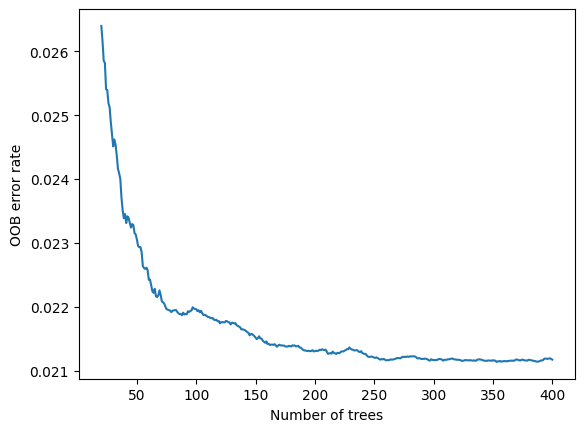

In [ ]:
error_rate = np.array([*error_rate])

plt.plot(error_rate[:, 0], error_rate[:, 1])
plt.xlabel("Number of trees")
plt.ylabel("OOB error rate")

Test RMSE: 0.1362789787769778
Train RMSE (OOB): 0.14166226720088418
